# Basic depth map processing

In [3]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.model_selection import train_test_split

def seed_everything(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Visualization

In [4]:
def depth_to_normals_3d(depth):
    h, w = depth.shape
    depth = depth.astype(np.float32)

    fx = w
    fy = w
    cx = w / 2
    cy = h / 2

    u, v = np.meshgrid(np.arange(w), np.arange(h))

    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth
    
    points = np.stack((x, y, z), axis=-1)
    dy, dx = np.gradient(points, axis=(0, 1))

    normals = np.cross(dx, dy)

    norm = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= (norm + 1e-8)

    normals_rgb = ((normals + 1) * 0.5 * 255).astype(np.uint8)
    return normals_rgb

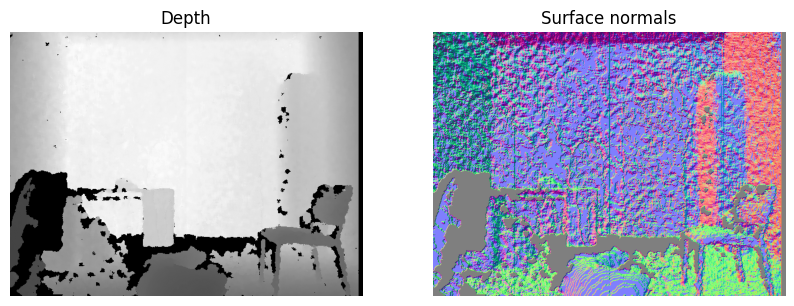

In [5]:
label = 'fall' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:
    depth = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    normals = depth_to_normals_3d(depth)

    clear_output(wait=True)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(depth, cmap='gray')
    plt.title("Depth")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(normals)
    plt.title("Surface normals")
    plt.axis("off")

    plt.show()

# Dataset

In [12]:
root = Path("../datasets")
out_root = Path("../datasets/data_normals")
out_root.mkdir(exist_ok=True)

for cls in ["adl", "fall"]:
    for seq in (root / cls).iterdir():
        out_seq = out_root / cls / seq.name
        out_seq.mkdir(parents=True, exist_ok=True)

        for f in seq.glob("*.png"):
            depth = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
            normals = depth_to_normals_3d(depth)

            np.save(out_seq / f"{f.stem}.npy", normals)


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, number_of_frames=64):
        self.samples = []
        self.transform = transform
        self.number_of_frames = number_of_frames

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                frames = sorted(seq_folder.glob("*.npy"))
                if frames:
                    self.samples.append((frames, label_idx))

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]

        if len(frame_paths) >= self.number_of_frames:
            frame_paths = frame_paths[-self.number_of_frames:]
        else:
            frame_paths = [frame_paths[0]] * (self.number_of_frames - len(frame_paths)) + frame_paths

        imgs = []
        for f in frame_paths:
            arr = np.load(f).astype(np.float32)          # (H, W, 3)
            img = Image.fromarray((arr * 255).astype(np.uint8)) # (3, H, W)

            if self.transform:
                img = self.transform(img)

            imgs.append(img)

        video = torch.stack(imgs)  # (T, 3, H, W)
        return video, label


    def __len__(self):
        return len(self.samples)




In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
root_dir = Path('../data_normals')

dataset = VideoDataset(root_dir, transform)

### Model

In [28]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model='resnet18', hidden_size=256, num_classes=2, pretrained=True):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(pretrained=pretrained)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        """
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)
        

        cnn_features = torch.stack(cnn_features, dim=1) # (B, T, feature_dim)
    
        lstm_out, _ = self.lstm(cnn_features) 
        last_time_step = lstm_out[:, -1, :] # (B, hidden_size)

        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [ ]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

# summary(model, input_size=(2, 256, 3, 224, 224), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_LSTM                                      [2, 2]                    --
├─Sequential: 1-1                             [2, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [2, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [2, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [2, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [2, 64, 56, 56]           --
│    └─Sequential: 2-5                        [2, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [2, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [2, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [2, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [2, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [2, 128, 28, 28]      

In [34]:
num_epochs = 10
batch_size = 4

# g = torch.Generator()
# g.manual_seed(42)
# seed_everything(42)

indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]
train_idx, val_idx = train_test_split(indices, test_size=0.15, stratify=labels, random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False, persistent_workers=True)


checkpoint_dir = Path('../models')
checkpoint_dir.mkdir(exist_ok=True, parents=True)
best_val_loss = 1e10

for epoch in range(num_epochs):
    # ===================== TRAIN =====================
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for i, (videos, labels) in enumerate(train_loader):
        videos = videos.to(device)   # (B, T, C, H, W)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)      # (B, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * videos.size(0)

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_dataset)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] TRAIN -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # ===================== VALIDATION =====================
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * videos.size(0)

            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] VAL   -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # ===================== CHECKPOINT =====================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = checkpoint_dir / f'best_model_normals.pt'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"\tSaved")


Epoch [1/10] TRAIN -> Loss: 0.6600, Accuracy: 59.32%
Epoch [1/10] VAL   -> Loss: 0.6263, Accuracy: 72.73%
	Saved
Epoch [2/10] TRAIN -> Loss: 0.5494, Accuracy: 79.66%
Epoch [2/10] VAL   -> Loss: 0.5188, Accuracy: 72.73%
	Saved
Epoch [3/10] TRAIN -> Loss: 0.4561, Accuracy: 83.05%
Epoch [3/10] VAL   -> Loss: 0.4534, Accuracy: 72.73%
	Saved
Epoch [4/10] TRAIN -> Loss: 0.3216, Accuracy: 91.53%
Epoch [4/10] VAL   -> Loss: 0.2974, Accuracy: 81.82%
	Saved
Epoch [5/10] TRAIN -> Loss: 0.2936, Accuracy: 88.14%
Epoch [5/10] VAL   -> Loss: 0.2588, Accuracy: 100.00%
	Saved
Epoch [6/10] TRAIN -> Loss: 0.2218, Accuracy: 93.22%
Epoch [6/10] VAL   -> Loss: 0.1273, Accuracy: 100.00%
	Saved
Epoch [7/10] TRAIN -> Loss: 0.2826, Accuracy: 89.83%
Epoch [7/10] VAL   -> Loss: 0.1073, Accuracy: 100.00%
	Saved
Epoch [8/10] TRAIN -> Loss: 0.1717, Accuracy: 93.22%
Epoch [8/10] VAL   -> Loss: 0.1238, Accuracy: 100.00%
Epoch [9/10] TRAIN -> Loss: 0.2900, Accuracy: 86.44%
Epoch [9/10] VAL   -> Loss: 0.1743, Accuracy: 

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


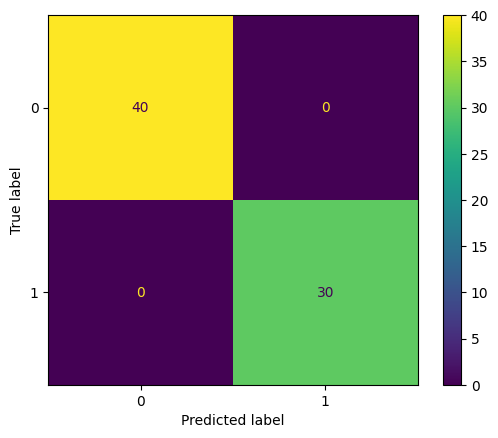

In [35]:
best_model_path = checkpoint_dir / 'best_model_normals.pt'
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for videos, labels in DataLoader(dataset, batch_size=4, shuffle=False):
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(videos)               # (B, num_classes)
        _, predicted = torch.max(outputs, 1)  # (B,)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall: {rec*100:.2f}%")
print(f"F1: {f1*100:.2f}%")

ConfusionMatrixDisplay(cm).plot()